In [8]:
import numpy as np
import pandas as pd

AAPL_CSV = 'archive/Technology Companies/AAPL.csv'

In [9]:
def load_data(csv_path):
    data=pd.read_csv(csv_path)
    data=data.copy()
    return data

In [10]:
def preprocess(data):
    """
    ## Prepare the data
    """
    # data["Change %"]=data["Change"].str.replace("%","") # edit change column to make it numeric
    # data["Change %"]=pd.to_numeric(data["Change %"]) 
    data['Date'] = pd.to_datetime(data.Date)
    # data['Close']=0
    # for i in range(1, len(data)):
    #   data.loc[i, 'Close'] = data.loc[i-1, 'Open'] # create close column
    # data['Volume']=data['Vol'].apply(lambda x: float(x[:-1]))
    return data



In [11]:
def create_date_table(start='2006-01-03', end='2020-11-20'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

# fill the empty data with 10 days moving average.
def fill_missing(data):
    data = data[["Date", "High", "Low", "Open", "Close", "Volume"]]
    date_data = create_date_table()
    df = date_data.merge(data, left_on="Date", right_on="Date", how="left")
    df = df[["Date", "High", "Low", "Open", "Close", "Volume"]]
    for column in df.columns:
        if df[column].dtypes != "<M8[ns]":
            df[column + "_MA"] = df[column].rolling(10, min_periods=1).mean()
            df[column].fillna(df[column + "_MA"], inplace=True)
    df["Date"] = df["Date"].astype(str)
    filled_df = df[["Date", "High", "Low", "Open", "Close", "Volume"]]
    return filled_df

data = load_data(AAPL_CSV)
data = preprocess(data)
data = fill_missing(data)
data

,Date,High,Low,Open,Close,Volume
0,2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0
1,2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0
2,2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0
3,2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0
4,2006-01-07,2.699375,2.634375,2.657054,2.682143,645179500.0
...,...,...,...,...,...,...
5431,2020-11-16,120.989998,118.150002,118.919998,120.300003,91183000.0
5432,2020-11-17,120.669998,118.959999,119.550003,119.389999,74271000.0
5433,2020-11-18,119.820000,118.000000,118.610001,118.029999,76322100.0
5434,2020-11-19,119.059998,116.809998,117.589996,118.639999,74113000.0


In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense , LSTM
from sklearn.metrics import mean_squared_error

In [13]:
training_set= data[['Open']]
training_set=pd.DataFrame(training_set)
training_set

,Open
0,2.585000
1,2.683214
2,2.672500
3,2.687500
4,2.657054
...,...
5431,118.919998
5432,119.550003
5433,118.610001
5434,117.589996


In [15]:
scaler=MinMaxScaler(feature_range=(0,1))
training_set_scaler=scaler.fit_transform(np.array(training_set).reshape(-1,1))
training_set_scaler

array([[0.00543308],
       [0.00615661],
       [0.00607768],
       ...,
       [0.86017646],
       [0.85266221],
       [0.86039746]])

In [17]:
train_size1= int(len(training_set_scaler)*0.65)
test_size1=int(len(training_set_scaler))-train_size1
train_data1,test_data1=training_set_scaler[0:train_size1,:],training_set_scaler[train_size1:len(data),:1]

In [18]:
train_size1

3533

In [19]:
def create_dataset(dataset,time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step=100
x_train, y_train=create_dataset(train_data1, time_step)
x_test, y_test= create_dataset(test_data1, time_step)

In [21]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics='acc')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 75, batch_size = 64, verbose = 1)

Epoch 1/75
54/54 [==============================] - 8s 102ms/step - loss: 9.5248e-04 - acc: 2.9138e-04 - val_loss: 0.0019 - val_acc: 5.5494e-04
Epoch 2/75
54/54 [==============================] - 5s 90ms/step - loss: 2.3509e-05 - acc: 2.9138e-04 - val_loss: 0.0027 - val_acc: 5.5494e-04
Epoch 3/75
54/54 [==============================] - 5s 90ms/step - loss: 2.1685e-05 - acc: 2.9138e-04 - val_loss: 0.0026 - val_acc: 5.5494e-04
Epoch 4/75
54/54 [==============================] - 5s 90ms/step - loss: 2.0431e-05 - acc: 2.9138e-04 - val_loss: 0.0028 - val_acc: 5.5494e-04
Epoch 5/75
54/54 [==============================] - 5s 93ms/step - loss: 1.9898e-05 - acc: 2.9138e-04 - val_loss: 0.0027 - val_acc: 5.5494e-04
Epoch 6/75
54/54 [==============================] - 5s 94ms/step - loss: 1.9731e-05 - acc: 2.9138e-04 - val_loss: 0.0025 - val_acc: 5.5494e-04
Epoch 7/75
54/54 [==============================] - 5s 93ms/step - loss: 1.8615e-05 - acc: 2.9138e-04 - val_loss: 0.0023 - val_acc: 5.5494e-0

In [23]:
train_predict1=model.predict(x_train)
test_predict1=model.predict(x_test)
#Transformback to original form
train_predict1=scaler.inverse_transform(train_predict1)
test_predict1=scaler.inverse_transform(test_predict1)

57/57 [==============================] - 1s 14ms/step


In [24]:
import math

math.sqrt(mean_squared_error(y_train,train_predict1))

15.443279049459562

In [25]:
math.sqrt(mean_squared_error(y_test,test_predict1))

53.51724858282547

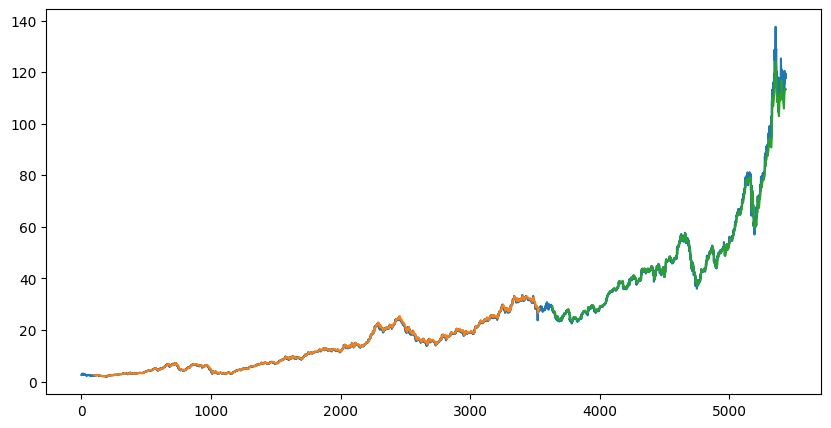

In [27]:
### Plotting
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(training_set_scaler)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict1) + look_back, :] = train_predict1

# shift test predictions for plotting
testPredictPlot = np.empty_like(training_set_scaler)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(train_predict1) + (look_back * 2) + 1 : len(training_set) - 1, :
] = test_predict1

from matplotlib import pyplot as plt

# plot baseline and predictions
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(training_set_scaler))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()